In [28]:
if 'google.colab' in str(get_ipython()):
    !rm -rf RL
    !git clone https://github.com/shamrous/RL.git
    import sys
    sys.path.append('/content/RL/Bandit')

Cloning into 'RL'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 18 (delta 1), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List
from Bandit import *

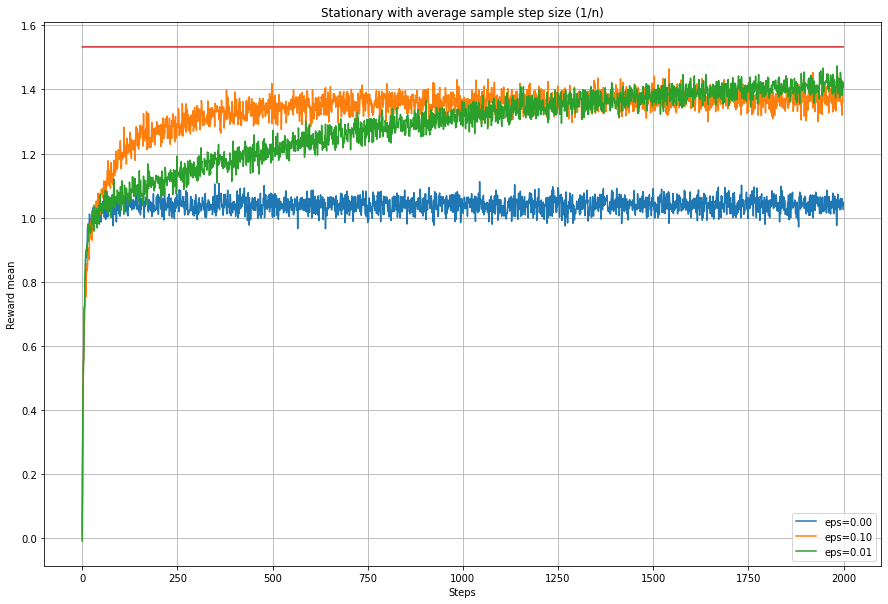

In [32]:
'''
Run stationary eps-greedy bandit with step size = 1/n, for different values of eps
The greedy method improved slightly faster than the other methods at the very beginning, but then leveled
of at a lower level. The greedy method performed significantly worse in the long run because it often got stuck performing suboptimal actions.
The eps-greedy methods eventually performed better because they continued to explore and to improve their chances of recognizing
the optimal action. 
'''
n_bandits = 2000
steps = 2000
arms = 10
mean = 0
stdev = 1
all_eps = [0., 0.1, 0.01]
plot_title = "Stationary with average sample step size (1/n)"
stationary = True
fn_step_size = None # 1/n is default

run_bandits_common(n_bandits, steps, arms, mean, stdev,
                all_eps, stationary, plot_title, fn_step_size)

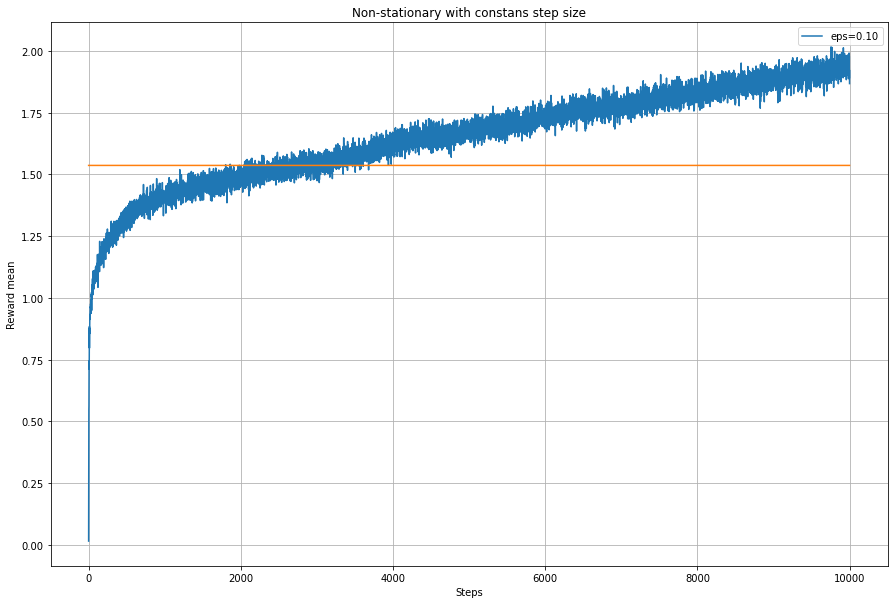

In [35]:
'''
Run non-stationary eps-greedy bandit with step size = 0.1
This example demonstrates that constant estimates never completely converge but
continue to vary in response to the most recently received rewards. As we mentioned
above, this is actually desirable in a nonstationary environment, and problems that are
effectively nonstationary are the most common in reinforcement learning.
'''
def const_step(alpha):
    def step(t):
        return alpha
    return step

n_bandits = 2000
steps = 10000
arms = 10
mean = 0
stdev = 1
all_eps = [0.1]
plot_title = "Non-stationary with constans step size"
stationary = False
fn_step_size = const_step(0.1)

run_bandits_common(n_bandits, steps, arms, mean, stdev,
                    all_eps, stationary, plot_title, fn_step_size)


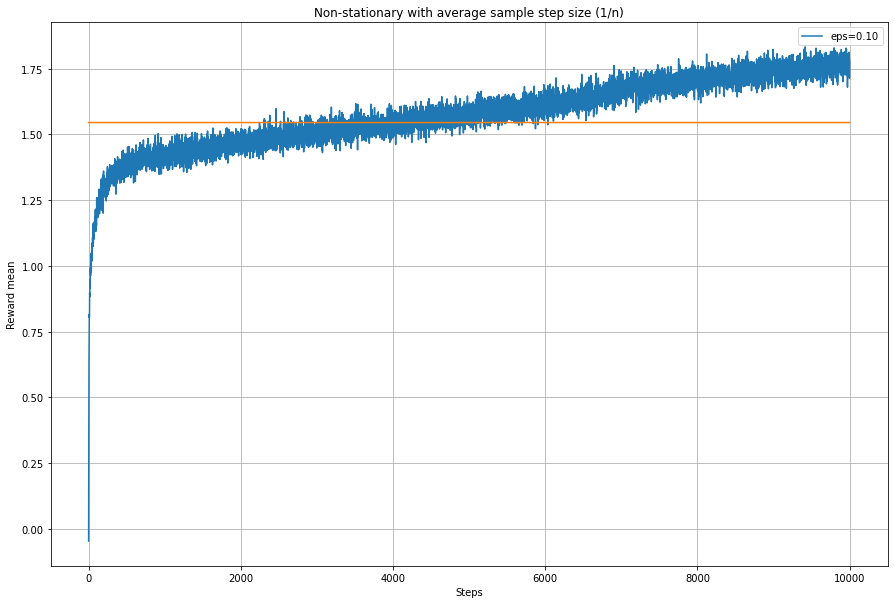

In [37]:
'''
Run non-stationary eps-greedy bandit with step size = 1/n
Step sizes that guarantee convergeness often converge very slowly or need considerable tuning in order to 
obtain a satisfactory convergence rate. 
Although sequences of step-size parameters that meet these convergence conditions are often used
in theoretical work, they are seldom used in applications and empirical research.
'''

n_bandits = 2000
steps = 10000
arms = 10
mean = 0
stdev = 1
all_eps = [0.1]
plot_title = "Non-stationary with average sample step size (1/n)"
stationary = False
fn_step_size = None # 1/n is default

run_bandits_common(n_bandits, steps, arms, mean, stdev,
                    all_eps, stationary, plot_title, fn_step_size)

